# Wind Turbine Digital twin
* working with MLFlow

In [1]:
!rm -rf wind_turbine
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 7.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 8.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.0/552.0 kB 7.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.2 MB/s eta 0:00:00
   ━

## Loading data

In [2]:
import pandas as pd
df = pd.read_csv("wind_turbine.csv")

## EDA

In [3]:
df.columns

Index(['wind_speed_ms', 'power_generated_kw'], dtype='object')

<Axes: xlabel='wind_speed_ms', ylabel='power_generated_kw'>

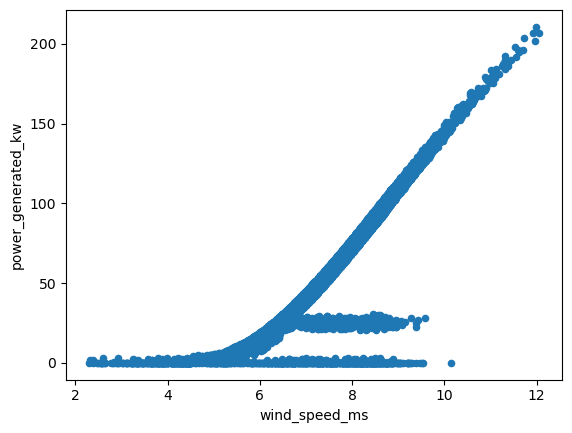

In [4]:
df.plot.scatter(x='wind_speed_ms', y='power_generated_kw')

## Model Development

In [5]:
import pandas as pd
import mlflow, os
import mlflow.sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import datetime

registered_model_name="wind_turbine"
n_estimators=100

# Start Logging
with mlflow.start_run() as run:
    # enable autologging
    mlflow.sklearn.autolog()
    mlflow.log_metric("num_samples", df.shape[0])
    mlflow.log_metric("num_features", df.shape[1] - 1)
    
    #Split train and test datasets
    train_df, test_df = train_test_split(
        df,
        test_size=0.3,
    )

    # build X,y and train,test datasets 
    y_train = train_df.pop("power_generated_kw")
    X_train = train_df.values
    y_test = test_df.pop("power_generated_kw")
    X_test = test_df.values

    # build the model
    reg = GradientBoostingRegressor(
        n_estimators=n_estimators
    )
    reg.fit(X_train, y_train)

    # test the model
    y_pred = reg.predict(X_test)
    
    print(r2_score(y_test, y_pred))
    mlflow.log_metric("r2_score_test", r2_score(y_test, y_pred))


    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=reg,
        registered_model_name=registered_model_name,
        artifact_path=registered_model_name,
    )
    
    # Saving the model to a file
    mlflow.sklearn.save_model(
        sk_model=reg,
        path=os.path.join(registered_model_name, "trained_model")
    )

    # Print the run id
    run_id = run.info.run_id
    print(f"Run ID: {run.info.run_id}")


2024/09/05 18:54:05 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


0.9362696939018997
Registering the model via MLFlow


2024/09/05 18:54:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'wind_turbine'.
2024/09/05 18:54:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: wind_turbine, version 1
Created version '1' of model 'wind_turbine'.
2024/09/05 18:54:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-cub-946 at: http://mlflow_server:5000/#/experiments/0/runs/6691f17dd4ab499cb71010251e0b80dd.
2024/09/05 18:54:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow_server:5000/#/experiments/0.


Run ID: 6691f17dd4ab499cb71010251e0b80dd


In [6]:
import mlflow
logged_model = f'runs:/{run_id}/wind_turbine'
logged_model = f'models:/wind_turbine/1'
print(f"Server the model with:\n mlflow models serve -m {logged_model} -p 5001")

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(X_test)

Server the model with:
 mlflow models serve -m models:/wind_turbine/1 -p 5001


array([100.42300109,  80.97644646,  70.50022471, ...,   2.57685424,
        14.22387276,  41.2902596 ])

In [7]:
%%writefile main.py
from fastapi import FastAPI
import mlflow
import pandas as pd
import numpy as np

app = FastAPI()
@app.post("/predict")
async def predict(X_test:float) -> list:
    logged_model = f'models:/wind_turbine/1'
    
    loaded_model = mlflow.pyfunc.load_model(logged_model)
    return list(loaded_model.predict(np.array([X_test]).reshape(-1, 1)))

Overwriting main.py
